In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")


from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [4]:
import tensorflow as tf
#for device in tf.config.list_physical_devices("GPU"):
#    tf.config.experimental.set_memory_growth(device, True)

In [5]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.experimental import ImageDataset, VideoDataset
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.experimental.net2net_v3 import Net2Net
import tensorflow_addons as tfa
from datetime import datetime
from tqdm.auto import tqdm
from pyprojroot.pyprojroot import here

tf.get_logger().setLevel('WARNING')
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [6]:
#strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())

In [7]:
cfg = omegaconf.OmegaConf.load(here("configs/kny_video_gpt2_large.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = cfg["train"]["batch_size"] 
global_batch_size = batch_size * strategy.num_replicas_in_sync
n_epochs = cfg["train"]["n_epochs"]
sample_batch_size = 8

In [8]:
#dataset_length = 1578 
#dataset_length = 10000
dataset_length = 35267
num_batch = dataset_length / batch_size

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    first_frame = element[0,...]
    last_frame = element[2,...]
    
    y = element[0:3,...]
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

In [9]:
drop_prob = 0.0 #0.2

def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = tf.cast(element, tf.float32) / 255.0
    #num_elements_to_keep = tf.random.uniform(shape=(1,), minval=5, maxval=tf.shape(element)[0], dtype=tf.int32)
    #remainder = tf.shape(element)[0] - num_elements_to_keep[0]
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    
    #element = element[:10,...]
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0]}

def video_to_ragged(element):
    element["y"] = tf.RaggedTensor.from_tensor(tf.expand_dims(element["y"], 0))
    return element
def squeeze_ragged(element):
    element["y"] = tf.squeeze(element["y"], axis=1)
    return element
def to_tensor(element):
    element["y"] = element["y"].to_tensor()
    return element

dataset = VideoDataset("../../../data/moving_mnist_tfrecords").load()
dataset = (dataset.shuffle(dataset_length, reshuffle_each_iteration=True)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           #.map(video_to_ragged, num_parallel_calls=tf.data.AUTOTUNE)
           )

train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

train_ds = dataset.take(train_size)#.batch(global_batch_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.batch(global_batch_size)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.batch(global_batch_size)

train_sample_data = next(train_ds
                          .padded_batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(batch_size).as_numpy_iterator())

train_ds = (train_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.apply(
                        tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size, drop_remainder=True))
            .prefetch(tf.data.AUTOTUNE))

In [10]:
# Normalizing the images to [-1, 1]
def normalize(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1

    return image

In [11]:
def preprocess(element):
    element = tf.reshape(element, (tf.shape(element)[0], tf.shape(element)[1], tf.shape(element)[2], 3))
    element = normalize(element)
    n_frames = tf.shape(element)[0]
    
    remaining_frames = tf.reverse(tf.range(n_frames), axis=[0])
    
    idx_to_keep = tf.random.uniform((tf.shape(element)[0],)) > drop_prob
    element = element[idx_to_keep]
    remaining_frames = remaining_frames[idx_to_keep]
    
    first_frame = element[0,...]
    last_frame = element[-1,...]
    
    y = element
    
    return {"first_frame": first_frame, "last_frame": last_frame, "y": y, "n_frames": tf.shape(element)[0], "remaining_frames": remaining_frames}
def postprocess(batch):
    min_frames = tf.reduce_min(batch["n_frames"])
    first_frame_idx = tf.constant(0)
    frames_to_keep = min_frames - 2
    
    y = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    remaining_frames = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    for i in tf.range(tf.shape(batch["y"])[0]):
        num_frames = batch["n_frames"][i]
        last_frame_idx = num_frames - 1
        all_indices = tf.range(1, num_frames - 1)
        indices = tf.sort(tf.random.shuffle(all_indices)[:frames_to_keep])
        indices = tf.concat([[first_frame_idx], indices, [last_frame_idx]], axis=0)
        y = y.write(i, tf.gather(batch["y"][i], indices))
        remaining_frames = remaining_frames.write(i, tf.gather(batch["remaining_frames"][i], indices))
        
    batch["remaining_frames"] = remaining_frames.stack()
    batch["y"] = y.stack()
    batch["n_frames"] = tf.repeat(min_frames, tf.shape(batch["y"])[0])
    
    return batch

In [12]:
dataset = VideoDataset("../../../data/kny/videos_tfrecords_full").load()
dataset = (dataset.shuffle(5000, reshuffle_each_iteration=True, seed=0)
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           )

In [13]:
train_size = int(dataset_length * 0.8)
validation_size = int(dataset_length * 0.1)
test_size = int(dataset_length * 0.1)

In [14]:
train_ds = dataset.take(train_size)
validation_ds = dataset.skip(train_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)
test_ds = dataset.skip(train_size + validation_size).take(validation_size)#.padded_batch(global_batch_size).map(postprocess)

In [15]:
train_sample_data = next(train_ds
                          .padded_batch(64)
                          #.map(postprocess)
                          .prefetch(tf.data.AUTOTUNE).as_numpy_iterator())
validation_sample_data = next(validation_ds.padded_batch(64)
                              #.map(postprocess)
                              .as_numpy_iterator())

In [16]:
train_ds = (train_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
validation_ds = (validation_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds.padded_batch(global_batch_size, drop_remainder=True)
            .map(postprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE))

In [17]:
take_train = [1, 8, 9, 12, 21, 25, 30, 47]
train_sample_data = postprocess({key: value[take_train] for key, value in train_sample_data.items()})
display_videos(train_sample_data["y"], n_rows=2, n_cols=4)

In [18]:
take_validation = [3, 8, 13, 16, 21, 33, 56, 61]
validation_sample_data = postprocess({key: value[take_validation] for key, value in validation_sample_data.items()})
display_videos(validation_sample_data["y"], n_rows=2, n_cols=4)

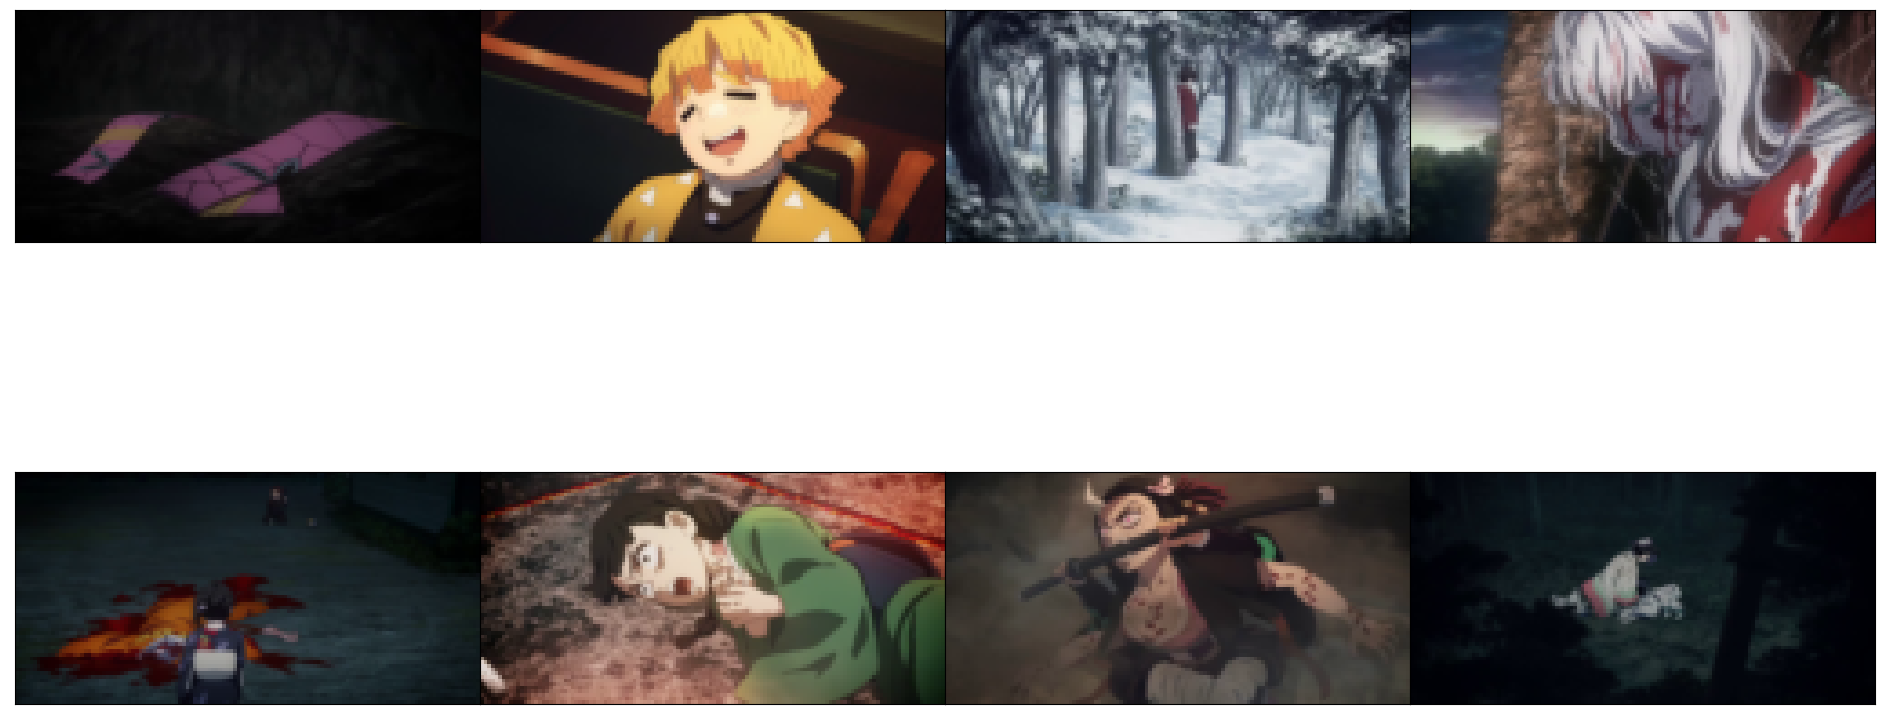

In [19]:
display_images(train_sample_data["first_frame"], 2, 4)
plt.show()

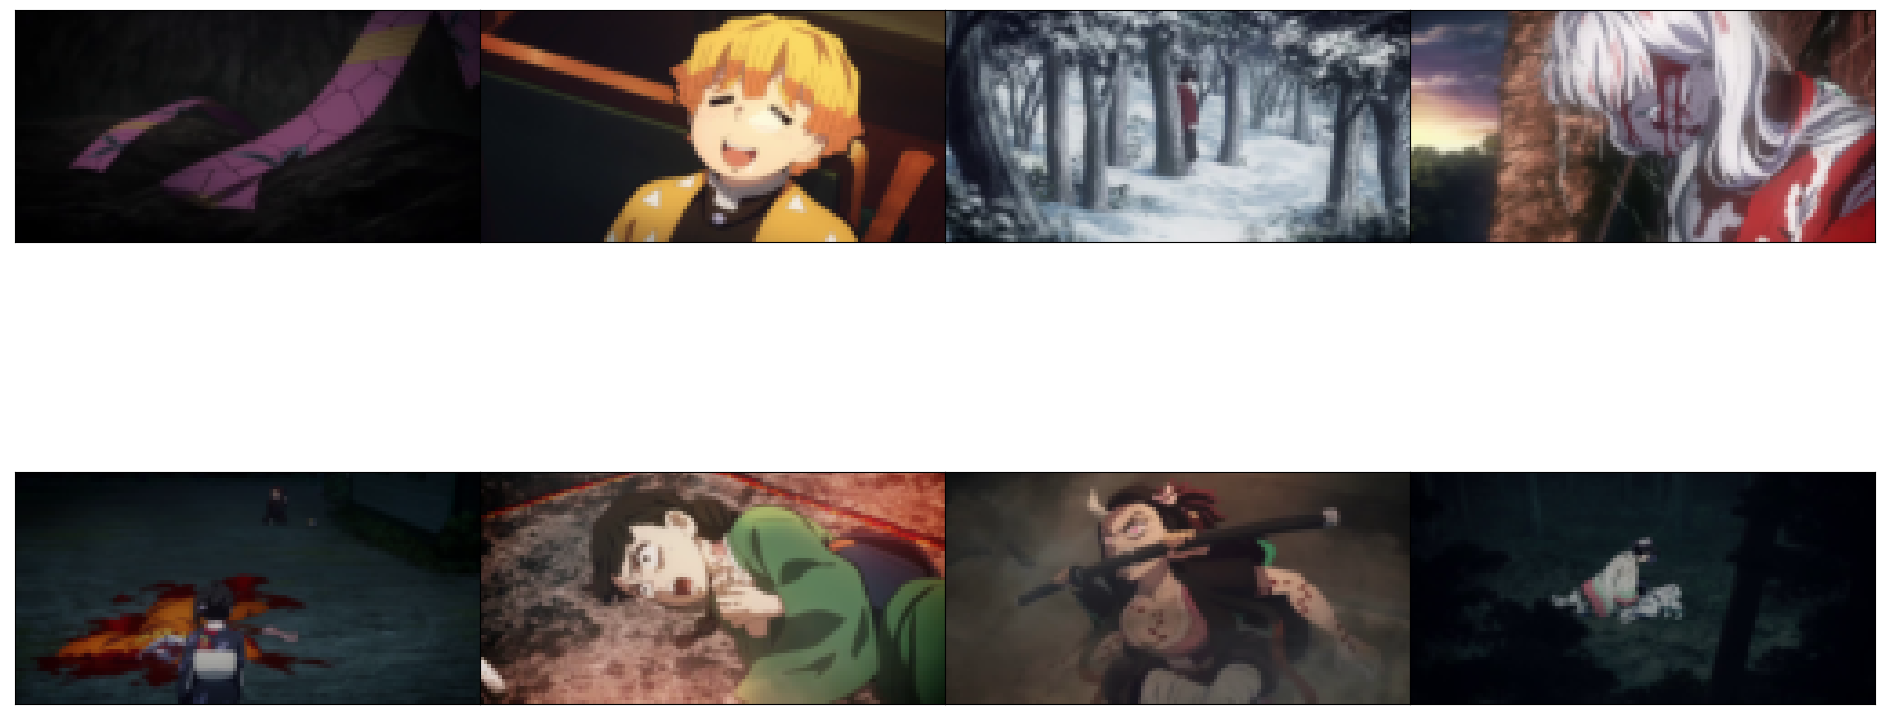

In [20]:
display_images(train_sample_data["last_frame"], 2, 4)
plt.show()

In [21]:
display_videos(train_sample_data["y"], n_rows=2, n_cols=4)

In [22]:
display_videos(validation_sample_data["y"], n_rows=2, n_cols=4)

In [23]:
train_sample_data["n_frames"]

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

train_ds = strategy.experimental_distribute_dataset(train_ds)
validation_ds = strategy.experimental_distribute_dataset(validation_ds)
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [24]:
from ganime.utils.callbacks import TensorboardVideo, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/transformers", experiment_name="kny_large")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
tensorboard_video_callback = TensorboardVideo(logdir, train_sample_data, validation_sample_data)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=50,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='total_loss', save_best_only=True, save_weights_only=True)
#callbacks = [tensorboard_callback, early_stopping, checkpointing, tensorboard_video_callback]
callbacks = [tensorboard_callback, checkpointing, tensorboard_video_callback]

In [25]:
with strategy.scope():
    model = Net2Net(**cfg["model"], trainer_config=cfg["train"], num_replicas=strategy.num_replicas_in_sync)
    #model.build(train_sample_data["y"].shape)#first_stage_model.build(train_sample_data["y"].shape[1:])
    model.first_stage_model.build(train_sample_data["y"].shape[1:])

Working with z of shape (1, 512, 16, 16) = 131072 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.
using method  own_embeddings


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

Some layers of TFGPT2LMHeadModel were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['transformer/weight:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


for i in range(10):
    pbar = tqdm(train_ds)
    for data in pbar:
        output = strategy.run(model.train_step, args=(data,))
        pbar.set_postfix(loss=output["loss"].numpy())

In [ ]:
model.fit(train_ds, validation_data=validation_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)
#model.fit(train_ds, epochs=cfg["train"]["n_epochs"], callbacks=callbacks)

Epoch 1/1000
143/143 [==============================] - 697s 4s/step - total_loss: 3.6761 - scce_loss: 2.7202 - perceptual_loss: 0.9559 - val_total_loss: 4.2754 - val_scce_loss: 2.9549 - val_perceptual_loss: 1.3205
Epoch 2/1000
143/143 [==============================] - 612s 4s/step - total_loss: 2.9904 - scce_loss: 2.0638 - perceptual_loss: 0.9267 - val_total_loss: 3.7525 - val_scce_loss: 2.3909 - val_perceptual_loss: 1.3617
Epoch 3/1000
143/143 [==============================] - 609s 4s/step - total_loss: 2.2829 - scce_loss: 1.6054 - perceptual_loss: 0.6775 - val_total_loss: 3.3677 - val_scce_loss: 2.0814 - val_perceptual_loss: 1.2862
Epoch 4/1000
143/143 [==============================] - 607s 4s/step - total_loss: 2.2570 - scce_loss: 1.3972 - perceptual_loss: 0.8598 - val_total_loss: 3.3334 - val_scce_loss: 1.9144 - val_perceptual_loss: 1.4190
Epoch 5/1000
143/143 [==============================] - 609s 4s/step - total_loss: 2.0617 - scce_loss: 1.2442 - perceptual_loss: 0.8175 - va